###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2021 Semester 1

## Assignment 1: Pose classification with naive Bayes


**Student ID(s):**     910519


### General Set Up
Before we begin we will need to import dependencies:

In [242]:
# Import dependencies
#________________________________________________
# General
import numpy as np
import pandas as pd
import time
#________________________________________________
# Calculating likelihoods
from scipy.stats import norm
from math import log, isnan

#________________________________________________
# Graphing data
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


... and define a function for preprocessing our data sets:

In [243]:
#_______________________________________________________________________________
# Preprocessing

# Takes a filepath to a .csv dataset, and returns a pandas data frame of the
# data, with values of 9999 replaced with "NaN"
def preprocess(filepath):
    with open(filepath, "r") as f:
        header = ["head_x", "shoulders_x", "elbowR_x", "wristR_x", "elbowL_x",\
                    "wristL_x", "hips_x", "kneeR_x", "footR_x", "kneeL_x", \
                    "footL_x", "head_y", "shoulders_y", "elbowR_y", "wristR_y",\
                    "elbowL_y", "wristL_y", "hips_y", "kneeR_y", "footR_y", \
                    "kneeL_y", "footL_y"]
        data = pd.read_csv(f,na_values = "9999", names = header)
    return data


Finally we will need a function for predicting classes over a whole dataset

In [244]:
#_______________________________________________________________________________
# Predicting data

# Takes a Classifier and a filepath to a test set (eg. "test.csv") and returns
# a list of predicted class
# made by the model
def predict_set(model, filepath):
    # Load the test data set and initialise our predictions space
    test = preprocess(filepath)
    predictions = []
    
    i = 0
    # For each test instance
    for instance in [test.iloc[i] for i in range(len(test))]:
        # Predict the result and add it to predictions
        predictions.append(model.predict(instance))
    
    return predictions

Now we're ready to rumble!

### Part 1: Gaussian Naïve Bayes Classifier
We will construct a Naïve Bayes Classifier Class, with the following methods:

1. train(filepath) - Takes in a filepath to a training data set in a csv file (eg. "train.csv") and assigns internal attributes relating to the training data (training the model)

2. predict(instance) - Takes a __single__ instance and returns a predicted class for it based on the trained model

The model will predict instances by creating a modified likelihood as follows:

$P(class|data) = \text{ln } P(class) + \sum\limits_{i = 1}^{n} \text{ln} P(attribute_i | class) $

Where the log is taken to prevent underflow when applying Bayes Law to calculate probabilities. This is also discussed in the code.

    

In [245]:
#_______________________________________________________________________________
# Gaussian Bayes
class Gaussian_Naive_Bayes:

    def train(self,training_filepath):
        # First we will process our data
        data = preprocess(training_filepath)
        
        # A Naive Bayes Learner will predict the class that maximises the 
        # posterior given the attributes seen, the equation we will use is
        #
        #    P(class|data) = (P(data|class) * P(class))/P(data))
        #
        # We will be ignoring P(data) since it does not assist in selecting a 
        # class and will store values used to compute the remaining 2 terms
        # as python dictionaries.
        
        
        #  ==> P(class)
        # The priors for each class are P(Class) = class_dict[class]/number of 
        # instances - ie. The proportion of each class in the data set:
        n_instances = len(data)
        priors = {}

        for _class in data.index.unique():
            priors[_class] = len(data[data.index == _class])/n_instances
        
        
        #  ==> P(data|class)
        #
        # We will also need the mean and standard deviation of
        # each attribute within each class  
        # To do so we will create a dictionary that maps each class-attribute 
        # combination to it's mean and standard deviation
        #
        # eg. params_dict[('bridge', 'head_x')] 
        #   = (2.17716120689655, 147.45625730166142)
        
        params_dict = {}
        # For each class
        for _class in data.index.unique():
            # Subset the data to the desired class, and fetch the mean
            # and standard deviation
            params = data[data.index == _class].describe(include='all').loc[\
                                                                ['mean','std']]
            # For each attribute
            for attribute in data.columns:
                # Map (class, attribute) to (mean, sd)
                params_dict[(_class, attribute)] = (params[attribute][0], \
                                                        params[attribute][1])

        # Assign our dictionaries internally
        self.priors = priors
        self.params_dict = params_dict

        # We will also keep track of the column names for referencing later
        self.columns = data.columns

        
    # Takes a single instance and returns a predicted class for it
    def predict(self, instance):
        # Initially our max probability and class values have not been assigned
        max_prob = None
        max_class = None
        
        # In order to combat underflow, instead of using the conventional
        # likelihood calculation we specified above, we will instead use
        # P(class|data) ~ Ln(P(class)) + Sum( Ln(P(data|class)) )
        
        # For each possible class
        for _class in list(self.priors):
            
            # Initialise the probability for this class with the first term,
            # log(P(class))
            prior = self.priors[_class]
            prob = log(prior)
            
            # For each attribute
            attr_index = 0
            for attr in instance:
                
                # Extract the mean and standard deviation for that attribute 
                # given the current class
                (mean, stddev) = self.params_dict[(_class, self.columns[attr_index])]
                
                # Calculate the likelihood of the data given this class
                likelihood = norm.pdf(attr, mean, stddev)
                
                # If the likelihood is valid
                if (not isnan(likelihood)) and likelihood != 0:
                    
                    # Add the log-likelihood to our ongoing sum
                    prob = prob + log(likelihood)
                
                # Move on to the next attribute
                attr_index = attr_index + 1
            
            # Once all attributes have been examined,
            # If this is the first class we've looked at or if this is a new 
            # maximum
            if (not max_prob) or (max_prob and (prob > max_prob)):
                # Reassign the new maximum value and class
                max_prob = prob
                max_class = _class
                
        # After looking at all possible classes, return the most likely
        return max_class
    
    # Returns a string representation identifying this classifier
    def get_name(self):
        return "Gaussian_NB"

### Part 2: KDE Naive Bayes Classifier (Question 3)
Similarly to the first part, we will construct a classifier class for our KDE Classifier.
The classifier will have the same methods as the Gaussian Naive Bayes, with the addition of:
    _KDE(x, data_points) - Takes an attribute value, and the data points which will be used to construct the KDE. Returns the result of the below equation:
    
$ KDE(x) = \frac{1}{N} \sum\limits_{i = 1}^{N} \phi (x - x_i) $

Where $\phi$ is the pdf of a normal distribution with mean 0 and $\sigma = $ the KDE Bandwidth (Default value is 5)

In [246]:
#_______________________________________________________________________________
# KDE
class KDE_Naive_Bayes:
    
    # In KDE, we take the list of data points for each attribute in each class
    # and store them for use when classifying new instances
    def train(self, filepath):

        # Fetch the training data
        data = preprocess(filepath)
        attr_class_dict = {}
        self.data = data
        # For each class
        for _class in self.data.index.unique():
            
            # Subset the data to that class
            subset = data[data.index == _class]

            # For each attribute
            for attr in data.columns:
                # Designate the data points for that attribute
                attr_class_dict[(_class, attr)] = subset[attr].tolist()
            
        # Add the dictionary as an attribute
        self.attr_class_dict = attr_class_dict
        
        # As with Gaussian Naive Bayes, We will also need the prior 
        # probabilities for each class
        n_instances = len(data)
        priors = {}

        for _class in data.index.unique():
            priors[_class] = len(data[data.index == _class])/n_instances
        
        self.priors = priors

        # Finally we will store the attribute names
        self.columns = data.columns
     
    # Predicts a class for a single instance
    def predict(self, instance):
        # Initially our max probability and class values have not been assigned
        max_prob = None
        max_class = None
        data = self.data
        
        # Cycle through and evaluate each possible class
        for _class in data.index.unique():
            
            # Initialise the probability for this class with the first term,
            # log(P(class))
            prior = self.priors[_class]
            prob = log(prior)
            # For each attribute
            attr_index = 0
            for attr in instance:
                
                # Fetch the data points for this attribute/class combination
                data_points = data[data.index == _class][self.columns[attr_index]]
            
                # Calculate the KDE for that attribute value and add it to our prob
                score = self._KDE(attr, data_points)
                
                # Guard against log(0)
                if score != 0:
                    prob += log(score)
                # If the prob was 0, just take an arbitrary high negative value to simulate the log(0)
                else:
                    prob -= 10000
                
                
                # Move on to the next attribute
                attr_index += 1
            
            # Once all attributes have been examined,
            # If this is the first class we've looked at or if this is a new maximum
            if (not max_prob) or (max_prob and (prob > max_prob)):
                # Reassign the new maximum value and class
                max_prob = prob
                max_class = _class
                
        # Return the predicted class
        return max_class
    
    # Takes a set of data points, an x value and optionally a bandwidth value, and
    # returns the KDE likelihood of that x value
    def _KDE(self, x, data_points, bandwidth = 5):
        N = len(data_points)
        _sum = 0
        for i in range(len(data_points)):
            # Ignore NaN values
            if (not np.isnan(data_points[i])) and (not np.isnan(x)):
                diff = x - data_points[i]
                _sum += norm.pdf(diff, 0, bandwidth)
        
        return _sum/N
    
    # Returns a string representation identifying this classifier
    def get_name(self):
        return "KDE"

## Part 3 - Evaluating the models
Now lets have a look at how well our respective models perform, first we will define some baseline classifiers

In [247]:
#_______________________________________________________________________________
# Zero R Classifier
class Zero_R_Classifier:
    def train(self,filepath):
        data = preprocess(filepath)
        # Work out the most common class and set it as our rule
        priors = {}
        for _class in data.index.unique():
            priors[_class] = len(data[data.index == _class])/len(data)
        
        max_prior = 0
        max_prior_class = None
        for _class in list(priors):
            if priors[_class] >= max_prior:
                max_prior = priors[_class]
                max_prior_class = _class
        self.rule = max_prior_class

    def predict(self, instance):
        return self.rule
    
    # Returns a string representation identifying this classifier
    def get_name(self):
        return "Zero_R"
#_______________________________________________________________________________
# Random Baseline

# Will make random guesses based on the class distribution in the training set
class Random_Classifier:
    def train(self,filepath):
        data = preprocess(filepath)
        # Work out the most common class and set it as our rule
        self.class_labels = data.index.unique()
        ordered_priors = []
        for _class in self.class_labels:
            ordered_priors.append(len(data[data.index == _class])/len(data))
            
        self.ordered_priors = ordered_priors

    def predict(self, instance):
        choice = np.random.choice(self.class_labels, 1, self.ordered_priors)[0]
        return choice
    
    # Returns a string representation identifying this classifier
    def get_name(self):
        return "Random"

### Confusion Matrices
A confusion matrix will be our primary means of identifying performance, as all true/positive false/negative values can be derived from it. Once generated, this matrix will be passed through various evaluation functions. Below is the code to generate a confusion matrix for a model, and some functions to calculate TP, FP and FN values.

In [248]:
# Evaluating Performance
#
#_______________________________________________________________________________
# Confusion matrix

# Takes a list of attribute names, predictions made and a list of true class 
# labels
# Returns a confusion matrix (pandas dataframe) representing the model's 
# performance
def create_cmatrix(attribute_names, predictions, true_labels):
    attribute_names = pd.Index(attribute_names)
    
    # Initialise the matrix with zeroes
    zeros = np.zeros(shape=(len(attribute_names),len(attribute_names)))
    df = pd.DataFrame(zeros, columns= attribute_names).set_index(attribute_names)
    
    # Add the frequency of each predicted/actual pair to the matrix
    for i in range(len(predictions)):
        df[predictions[i]][true_labels[i]] += 1
        
    # Accuracy is sum(np.diag(df))/len(predictions)
    return df

#_______________________________________________________________________________
# Identifying positive and negative results

# True positives - Number of times we predicted this class and were correct 
def true_pos(cmatrix, _class):
    return cmatrix[_class][_class]

# False Positives - Number of times we predicted this class and were wrong
def false_pos(cmatrix, _class):
    return sum(cmatrix[_class]) - true_pos(cmatrix, _class)

# False negatives, how many times was it actually this class but we guessed
# something else
def false_neg(cmatrix, _class):
    # Actual classes are the rows in our cmatrix
    return sum(cmatrix.loc[_class, :]) - true_pos(cmatrix, _class)

# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)
def class_precision(cmatrix, _class):
    
    _TP = true_pos(cmatrix,_class)
    
    _FP = false_pos(cmatrix,_class)
    if (_TP + _FP) != 0:
        return _TP / (_TP + _FP)
    else:
        return 0

def class_recall(cmatrix, _class):

    _TP = true_pos(cmatrix,_class)

    _FN = false_neg(cmatrix, _class)
    
    if (_TP + _FN) != 0:
        return _TP / (_TP + _FN)
    else:
        return 0


### Multiclass Evaluation Methods (Question 1)
Below are several methods for calculating precision and recall for our multiclass model

In [249]:
#_______________________________________________________________________________
# Producing (Precision, Recall) tuples for multiclass evaluation

# Macro-averaging: calculate P,R per class and take mean
def macro_average(cmatrix):
    precision_sum = 0
    recall_sum = 0
    for _class in cmatrix.columns:
        precision_sum += class_precision(cmatrix, _class)
        recall_sum += class_recall(cmatrix, _class)
    return (precision_sum/len(cmatrix), recall_sum/len(cmatrix))

# Micro-averaging: combine all instances into one pool:
#     Precision = sum(TP)/sum(TP + FP)
#     Recall = sum(TP)/sum(TP + FN)
def micro_average(cmatrix):
    tp_sum = 0
    tp_fp_sum = 0
    tp_fn_sum = 0
    for _class in cmatrix.columns:
        tp = true_pos(cmatrix,_class)
        tp_sum += tp
        tp_fp_sum += tp + false_pos(cmatrix,_class)
        tp_fn_sum += tp + false_neg(cmatrix, _class)
        
    return (tp_sum/tp_fp_sum, tp_sum/tp_fn_sum)

# Weighted averaging: calculate P,R per class and take mean, weighted by
# proportion of instances in that class
def weighted_average(cmatrix):
    n_instances = sum(cmatrix.sum())
    precision = 0
    recall = 0
    # For each row of actual values
    for _class in cmatrix.columns:
            # Extract the actual number of instances of this class in the
            # test set
            values = cmatrix.loc[_class]
            # Divide through by the total number of instances to get the
            # class proportion
            class_proportion = values.sum()/n_instances
            
            # Scale the precision and recall for this class by the class
            # proportion
            precision += class_proportion * class_precision(cmatrix, _class)
            recall += class_proportion * class_recall(cmatrix, _class)
    return (precision, recall)



### Evaluate()
In light of the versatility and usefulness of confusion matrices, our evaluate function will simply run a given model against some test data and return only the confusion matrix produced during the test

In [250]:
#_______________________________________________________________________________
# Overall evaluation

# Takes a Classifier and a filepath to a test set (eg. "test.csv") and returns
# a confusion matrix representing the model's performance
def evaluate(model, filepath):
    true_labels = preprocess(filepath).index
    predictions = predict_set(model, filepath)
    # Establish which attributes come up in this test
    attributes_seen = list(set(true_labels.unique().tolist() + predictions))

    cmatrix = create_cmatrix(attributes_seen, predictions, true_labels)
    
    return cmatrix

### Graphing results
Below are several functions used to produce comparisons and graphical representations of the data

In [271]:
#_______________________________________________________________________________
# Functions for graphics
def get_heatmap(model_name, cmatrix):
    plt.tight_layout()
    sns.heatmap(cmatrix, annot=True, fmt="g", cmap='viridis')
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    #plt.title(f"Confusion Heatmap: {model_name}")
    plt.savefig(f'results/confusion_heatmap_{model_name}.jpg', bbox_inches='tight')
    plt.clf()
    
def multiclass_precision_recall(model_name, cmatrix):
    macro = macro_average(cmatrix)
    micro = micro_average(cmatrix)
    weighted = weighted_average(cmatrix)
    # weighted = weighted_average(cmatrix)
    labels = ["macro averaged result: ", "micro averaged result: ", "weighted\n average result: "]
    evals = [macro,micro, weighted]
    
    fig, ax = plt.subplots()
    
    ax.set_xlabel("Precision")
    x = [_eval[0] for _eval in evals]
    
    ax.set_ylabel("Recall")
    y = [_eval[1] for _eval in evals]
    
    ax.scatter(x,y, s = 20)
    
    
    # Annotate the plot (Some fmagic numbers here to help fit the annotations on the graph)
    ax.annotate(f"{labels[0]}({round(macro[0],2)},{round(macro[1],2)})", \
                    (macro[0] + 0.001, macro[1]))
    ax.annotate(f"{labels[1]}({round(micro[0],2)},{round(micro[1],2)})", \
                    (micro[0]- 0.017, micro[1] - 0.0001))
    ax.annotate(f"{labels[2]}({round(weighted[0],2)},{round(weighted[1],2)})", \
                    (weighted[0] - 0.005, weighted[1] - 0.0008))
    
    plt.savefig(f"results/multiclass_eval_scatter_{model_name}.jpg", bbox_inches = 'tight')
    plt.clf()
    return

# Takes two confusion matrices with model names and generates a bar chart
# to evaluate recall over different classes
def generate_recall_comparison(name1, cmatrix1, name2, cmatrix2):
    # define labels and results
    labels = cmatrix1.columns.tolist()
    results1 = []
    results2 = []
    
    for column in labels:
        results1.append(class_recall(cmatrix1, column))
        results2.append(class_recall(cmatrix2, column))
        
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    # Define space for the bars to live
    rects1 = ax.bar(x - width/2, results1, width, label= name1)
    rects2 = ax.bar(x + width/2, results2, width, label= name2)
              
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Recall')
    ax.set_title(f'Recall over individual classes')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation = "vertical")
    ax.legend()
    
    
    fig.tight_layout()
    plt.savefig(f'results/Recall_comparison_{name1}_{name2}.jpg', bbox_inches='tight')
    plt.show()
    plt.clf()
    
# Takes two confusion matrices with model names and generates a bar chart
# to evaluate recall over different classes
def generate_precision_comparison(name1, cmatrix1, name2, cmatrix2):
    # define labels and results
    labels = cmatrix1.columns.tolist()
    results1 = []
    results2 = []
    
    for column in labels:
        results1.append(class_precision(cmatrix1, column))
        results2.append(class_precision(cmatrix2, column))
        
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    # Define space for the bars to live
    rects1 = ax.bar(x - width/2, results1, width, label= name1)
    rects2 = ax.bar(x + width/2, results2, width, label= name2)
              
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision over individual classes')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation = "vertical")
    ax.legend()
    
    
    fig.tight_layout()
    plt.savefig(f'results/Precision_comparison_{name1}_{name2}.jpg', bbox_inches='tight')
    plt.show()
    plt.clf()
    
#_________________________________________________________________________
# Tool for rendering pandas dataframes as tables,
# Code here is taken from stack overflow user volodymyr
# https://stackoverflow.com/questions/19726663/how-to-save-the-pandas-dataframe-series-data-as-a-figure
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax


## Part 4: Tests / Running the models
Here we will actually construct some instances of our test models and use them to create some data for analysis

In [252]:
# Instantiate the models
nb = Gaussian_Naive_Bayes()
kde = KDE_Naive_Bayes()
zero_R = Zero_R_Classifier()
rc = Random_Classifier()

models = [nb, kde, zero_R, rc ]

In [253]:
# Train the models
for model in models:
    model.train("train.csv")


In [283]:
# Run an evaluation on the models
names = [model.get_name() for model in models]
time_df = pd.DataFrame(columns = ["Model", "Execution Time(seconds)"])
cmatrices = []

# First we must collect the relevant confusion matrices for each model.
# We will also track the time taken to evaluate the model.
for model in models:
    # Log the start time
    start = time.time()
    
    # Run the predictions and fetch a confusion matrix
    cmatrices.append(evaluate(model, "test.csv"))
    
    # Log the end time
    end = time.time()
    
    # Add the execution time to our time dataframe
    time_df.loc[len(time_df)] = [model.get_name(), end - start]
    

KeyboardInterrupt: 

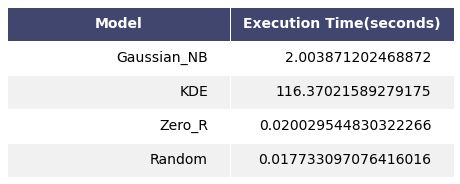

In [255]:
# Render and save time results
fig,ax = render_mpl_table(time_df, header_columns=0, col_width=4.0)
fig.savefig("results/time_table.png")

In [256]:
# Now we will turn our confusion matrices into some savable figures for analysis:
for i in range(len(cmatrices)):
    get_heatmap(names[i], cmatrices[i])
# These will be saved to our results folder

<Figure size 432x288 with 0 Axes>

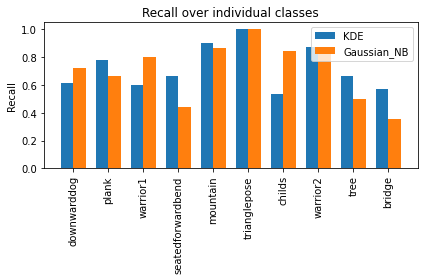

<Figure size 432x288 with 0 Axes>

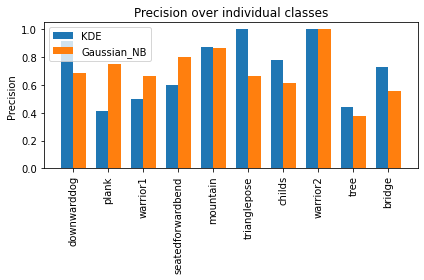

<Figure size 432x288 with 0 Axes>

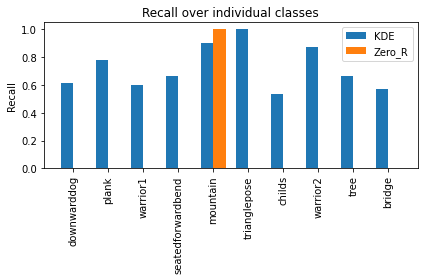

<Figure size 432x288 with 0 Axes>

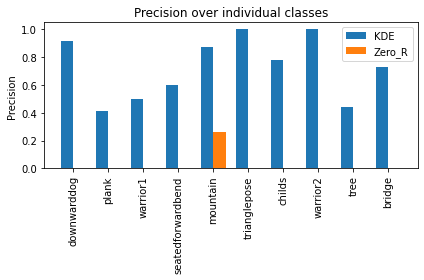

<Figure size 432x288 with 0 Axes>

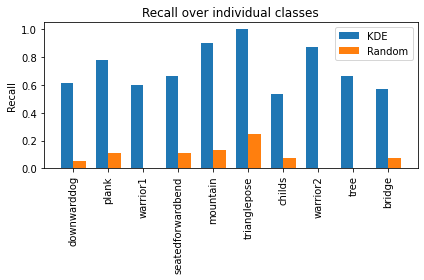

<Figure size 432x288 with 0 Axes>

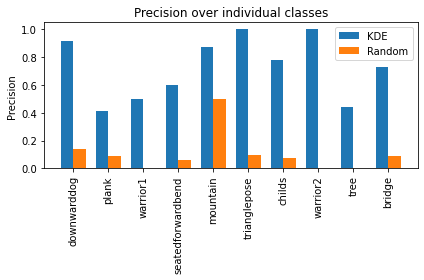

<Figure size 432x288 with 0 Axes>

In [257]:
# Generate some comparisons
# Gaussian vs KDE
generate_recall_comparison(names[1], cmatrices[1], names[0], cmatrices[0])
generate_precision_comparison(names[1], cmatrices[1], names[0], cmatrices[0])
# zero R vs KDE
generate_recall_comparison(names[1], cmatrices[1], names[2], cmatrices[2])
generate_precision_comparison(names[1], cmatrices[1], names[2], cmatrices[2])
# Random Classifier vs KDE
generate_recall_comparison(names[1], cmatrices[1], names[3], cmatrices[3])
generate_precision_comparison(names[1], cmatrices[1], names[3], cmatrices[3])



In [258]:
# Create a scatter plot of the various methods for calculating precision, recall
# for the Gaussian Naive Bayes
multiclass_precision_recall(models[0].get_name(), cmatrices[0])


<Figure size 432x288 with 0 Axes>

In [287]:
# Generate a table of performance stats for our models
def generate_performance_stats(cmatrix):
    accuracy = sum(np.diag(cmatrix))/sum(cmatrix.sum())
    wt_av = weighted_average(cmatrix)
    return [100 * accuracy, 100 * wt_av[0], 100 * wt_av[1]]

df = pd.DataFrame(columns = ["Model", "Accuracy (%)", "Weighted Precision (%)", "Weighted Recall (%)"])
df.set_index('Model')
for i in range(len(cmatrices)):
    row = [models[i].get_name()]
    performance_stats = generate_performance_stats(cmatrices[i])
    # Round the stats to 3 decimal places
    performance_stats = [round(x, 3) for x in performance_stats]
    row += performance_stats
    df_len = len(df)
    df.loc[df_len] = row

# Render and save the table
fig,ax = render_mpl_table(df, header_columns=0, col_width=4.0)
fig.savefig("results/stats_table.png")
# Clear pyplot
plt.clf()

<Figure size 1152x90 with 0 Axes>

In [282]:
df

,Model,Accuracy (%),Weighted Precision,Weighted Recall
0,Gaussian_NB,71.552,0.726,0.716
1,KDE,72.414,0.769,0.724
2,Zero_R,25.862,0.067,0.259
3,Random,8.621,0.186,0.086
